In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import BSpline
from scipy.linalg import svd
from splines import bspline_basis, PenalizedSpline, RegressionSpline, NaturalCubicSpline
from gam import GAM

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
%matplotlib inline
np.random.seed(42)

## 1. Spline Basis Functions

### 1.1 Truncated Power Basis

A **truncated power basis** of degree $d$ with knots $\xi_1, \ldots, \xi_K$ consists of:

$$1, x, x^2, \ldots, x^d, (x - \xi_1)_+^d, (x - \xi_2)_+^d, \ldots, (x - \xi_K)_+^d$$

where $(u)_+ = \max(0, u)$.

**Properties**:
- Simple to understand
- Numerically unstable for high degrees
- Poor conditioning of design matrix

### 1.2 B-Spline Basis

**B-splines** provide a numerically stable alternative with **local support**.

For degree $d$ and knot sequence $t_1, \ldots, t_m$, B-splines are defined recursively:

$$B_{i,0}(x) = \begin{cases} 1 & \text{if } t_i \leq x < t_{i+1} \\ 0 & \text{otherwise} \end{cases}$$

$$B_{i,d}(x) = \frac{x - t_i}{t_{i+d} - t_i} B_{i,d-1}(x) + \frac{t_{i+d+1} - x}{t_{i+d+1} - t_{i+1}} B_{i+1,d-1}(x)$$

**Key Properties**:
1. **Partition of unity**: $\sum_{i=1}^{m} B_{i,d}(x) = 1$ for all $x$
2. **Non-negativity**: $B_{i,d}(x) \geq 0$
3. **Local support**: $B_{i,d}(x) = 0$ outside $[t_i, t_{i+d+1}]$
4. **Numerical stability**: Well-conditioned basis matrices

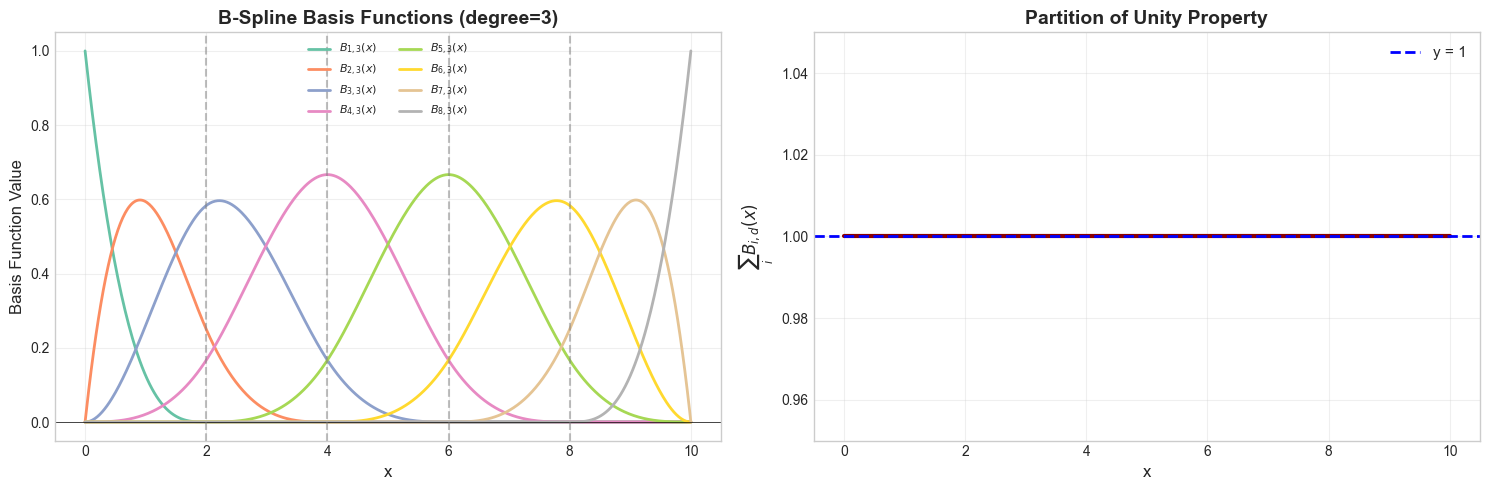

✓ B-spline basis matrix shape: (500, 8)
✓ Number of basis functions: 8 = 4 knots + 3 + 1
✓ Partition of unity: min=1.0000000000, max=1.0000000000


In [2]:
x_grid = np.linspace(0, 10, 500)
knots = np.array([2, 4, 6, 8])
degree = 3

B = bspline_basis(x_grid, knots, degree=degree)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for j in range(B.shape[1]):
    axes[0].plot(x_grid, B[:, j], linewidth=2, label=f'$B_{{{j+1},{degree}}}(x)$')

axes[0].axhline(0, color='black', linewidth=0.5)
for knot in knots:
    axes[0].axvline(knot, color='gray', linestyle='--', alpha=0.5)
axes[0].set_xlabel('x', fontsize=12)
axes[0].set_ylabel('Basis Function Value', fontsize=12)
axes[0].set_title(f'B-Spline Basis Functions (degree={degree})', fontsize=14, fontweight='bold')
axes[0].legend(ncol=2, fontsize=8)
axes[0].grid(True, alpha=0.3)

row_sums = np.sum(B, axis=1)
axes[1].plot(x_grid, row_sums, linewidth=3, color='darkred')
axes[1].axhline(1, color='blue', linestyle='--', linewidth=2, label='y = 1')
axes[1].set_xlabel('x', fontsize=12)
axes[1].set_ylabel(r'$\sum_{i} B_{i,d}(x)$', fontsize=12)
axes[1].set_title('Partition of Unity Property', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0.95, 1.05])

plt.tight_layout()
plt.show()

print(f"✓ B-spline basis matrix shape: {B.shape}")
print(f"✓ Number of basis functions: {B.shape[1]} = {len(knots)} knots + {degree} + 1")
print(f"✓ Partition of unity: min={row_sums.min():.10f}, max={row_sums.max():.10f}")

## 2. Penalized Regression Framework

### 2.1 Smoothing Splines

**Smoothing splines** minimize the penalized residual sum of squares:

$$\hat{f} = \arg\min_{f \in \mathcal{H}} \sum_{i=1}^{n} (y_i - f(x_i))^2 + \lambda \int [f''(x)]^2 dx$$

where:
- First term: fidelity to data
- Second term: penalty on curvature
- $\lambda \geq 0$: smoothing parameter

**Solution**: Natural cubic spline with knots at each unique $x_i$.

### 2.2 Penalized Splines (P-Splines)

**P-splines** (Eilers & Marx, 1996) use B-spline basis with **difference penalties**:

$$\hat{\beta} = \arg\min_{\beta} \|y - B\beta\|^2 + \lambda \beta^T P \beta$$

where $P = D^T D$ is the penalty matrix and $D$ is the $m$-th order difference operator.

**Difference Operators**:
- First order ($m=1$): Penalizes jumps in $\beta$ (roughness of $f$)
- Second order ($m=2$): Penalizes curvature (most common)
- Third order ($m=3$): Penalizes rate of curvature change

**Closed-form solution**:

$$\hat{\beta} = (B^T B + \lambda P)^{-1} B^T y$$

**Hat matrix**:

$$H = B(B^T B + \lambda P)^{-1} B^T$$

with $\hat{y} = Hy$.

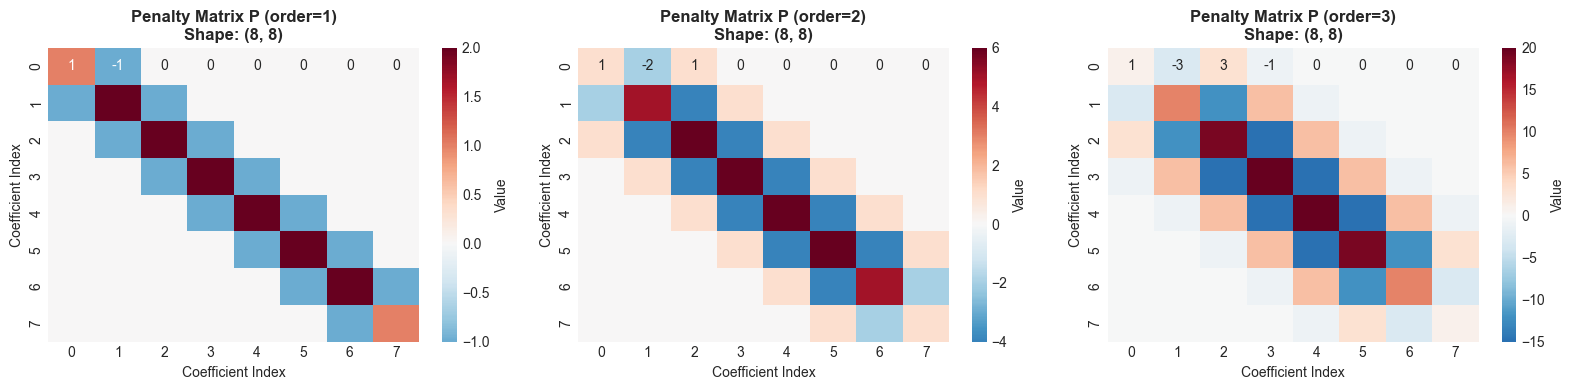

Penalty Matrix Properties:
Order 1: Shape (8, 8), Rank 7, Null space dim = 1
Order 2: Shape (8, 8), Rank 6, Null space dim = 2
Order 3: Shape (8, 8), Rank 5, Null space dim = 3


In [3]:
n_basis = 8

def difference_matrix(n, order):
    D = np.eye(n)
    for _ in range(order):
        D = np.diff(D, axis=0)
    return D

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for i, order in enumerate([1, 2, 3]):
    D = difference_matrix(n_basis, order)
    P = D.T @ D
    
    sns.heatmap(P, annot=True, fmt='.0f', cmap='RdBu_r', center=0, 
                cbar_kws={'label': 'Value'}, ax=axes[i])
    axes[i].set_title(f'Penalty Matrix P (order={order})\nShape: {P.shape}', 
                      fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Coefficient Index')
    axes[i].set_ylabel('Coefficient Index')

plt.tight_layout()
plt.show()

print("Penalty Matrix Properties:")
print("=" * 60)
for order in [1, 2, 3]:
    D = difference_matrix(n_basis, order)
    P = D.T @ D
    rank = np.linalg.matrix_rank(P)
    print(f"Order {order}: Shape {P.shape}, Rank {rank}, Null space dim = {n_basis - rank}")

## 3. Effective Degrees of Freedom

### 3.1 Definition

The **effective degrees of freedom (edf)** quantifies model complexity:

$$\text{df}(\lambda) = \text{tr}(H) = \text{tr}\left(B(B^T B + \lambda P)^{-1} B^T\right)$$

**Properties**:
- When $\lambda = 0$: $\text{df} = p$ (number of basis functions)
- When $\lambda \to \infty$: $\text{df} \to \text{rank}(P^\perp)$ (null space dimension)
- Monotone decreasing in $\lambda$

### 3.2 Bayesian Interpretation

P-splines have a **Bayesian interpretation**:

$$p(\beta \mid \sigma^2, \lambda) \propto \exp\left(-\frac{1}{2\sigma^2} \beta^T P \beta\right)$$

This is a Gaussian prior with precision matrix $P/\sigma^2$.

The posterior mean is:

$$E[\beta \mid y] = (B^T B + \lambda P)^{-1} B^T y$$

which is **identical** to the penalized least squares solution!

### 3.3 Variance Estimation

**Residual variance**:

$$\hat{\sigma}^2 = \frac{\|y - \hat{y}\|^2}{n - \text{df}(\lambda)}$$

**Covariance of coefficients**:

$$\text{Cov}(\hat{\beta}) = \sigma^2 (B^T B + \lambda P)^{-1} B^T B (B^T B + \lambda P)^{-1}$$

**Pointwise standard errors**:

$$\text{se}(\hat{f}(x_0)) = \sqrt{b(x_0)^T \text{Cov}(\hat{\beta}) \, b(x_0)}$$

where $b(x_0)$ is the B-spline basis vector at $x_0$.

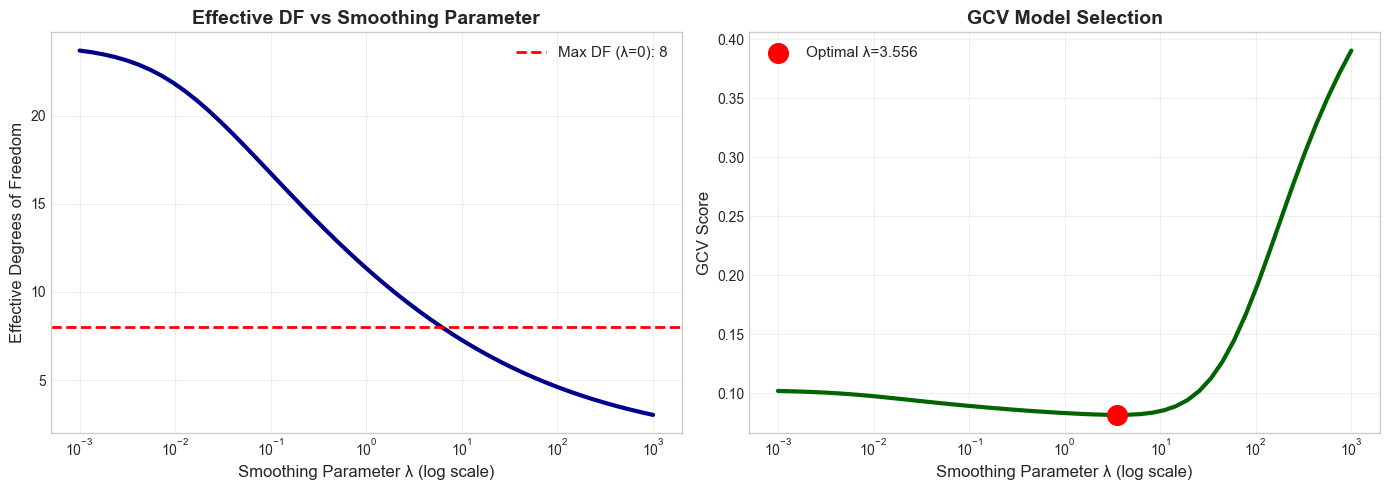

Effective Degrees of Freedom Analysis:
λ = 0.0010 (small):  edf = 23.70
λ = 1000.0000 (large): edf = 3.02

Optimal λ = 3.5565: edf = 8.91

✓ As λ increases, effective DF decreases monotonically
✓ GCV balances fit and complexity to select optimal λ


In [4]:
np.random.seed(42)
n = 100
x = np.linspace(0, 10, n)
y = np.sin(x) + np.random.normal(0, 0.3, n)

lambdas = np.logspace(-3, 3, 50)
edfs = []
gcv_scores = []

for lam in lambdas:
    model = PenalizedSpline(n_knots=20, degree=3, lambda_=lam, diff_order=2)
    model.fit(x, y)
    edfs.append(model.effective_df())
    gcv_scores.append(model.gcv_score())

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].semilogx(lambdas, edfs, linewidth=3, color='darkblue')
axes[0].axhline(len(knots) + degree + 1, color='red', linestyle='--', 
                label=f'Max DF (λ=0): {len(knots) + degree + 1}', linewidth=2)
axes[0].set_xlabel('Smoothing Parameter λ (log scale)', fontsize=12)
axes[0].set_ylabel('Effective Degrees of Freedom', fontsize=12)
axes[0].set_title('Effective DF vs Smoothing Parameter', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

axes[1].semilogx(lambdas, gcv_scores, linewidth=3, color='darkgreen')
min_idx = np.argmin(gcv_scores)
axes[1].scatter(lambdas[min_idx], gcv_scores[min_idx], s=200, color='red', 
                zorder=5, label=f'Optimal λ={lambdas[min_idx]:.3f}')
axes[1].set_xlabel('Smoothing Parameter λ (log scale)', fontsize=12)
axes[1].set_ylabel('GCV Score', fontsize=12)
axes[1].set_title('GCV Model Selection', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Effective Degrees of Freedom Analysis:")
print("=" * 60)
print(f"λ = {lambdas[0]:.4f} (small):  edf = {edfs[0]:.2f}")
print(f"λ = {lambdas[-1]:.4f} (large): edf = {edfs[-1]:.2f}")
print(f"\nOptimal λ = {lambdas[min_idx]:.4f}: edf = {edfs[min_idx]:.2f}")
print(f"\n✓ As λ increases, effective DF decreases monotonically")
print(f"✓ GCV balances fit and complexity to select optimal λ")

## 4. Model Selection: Generalized Cross-Validation

### 4.1 GCV Criterion

**Generalized Cross-Validation (GCV)** provides automatic smoothing parameter selection:

$$\text{GCV}(\lambda) = \frac{n \cdot \text{RSS}(\lambda)}{[n - \text{df}(\lambda)]^2}$$

where $\text{RSS}(\lambda) = \|y - \hat{y}_\lambda\|^2$.

**Interpretation**: Approximation to leave-one-out cross-validation without actually refitting $n$ times.

**Alternative: AIC and BIC**

$$\text{AIC}(\lambda) = n \log(\text{RSS}(\lambda)/n) + 2 \cdot \text{df}(\lambda)$$

$$\text{BIC}(\lambda) = n \log(\text{RSS}(\lambda)/n) + \log(n) \cdot \text{df}(\lambda)$$

### 4.2 K-Fold Cross-Validation

For finite samples, **K-fold CV** provides unbiased assessment:

$$\text{CV}_K(\lambda) = \frac{1}{n} \sum_{k=1}^{K} \sum_{i \in \mathcal{F}_k} (y_i - \hat{f}_{-k}(x_i; \lambda))^2$$

where $\hat{f}_{-k}$ is fitted without fold $k$.

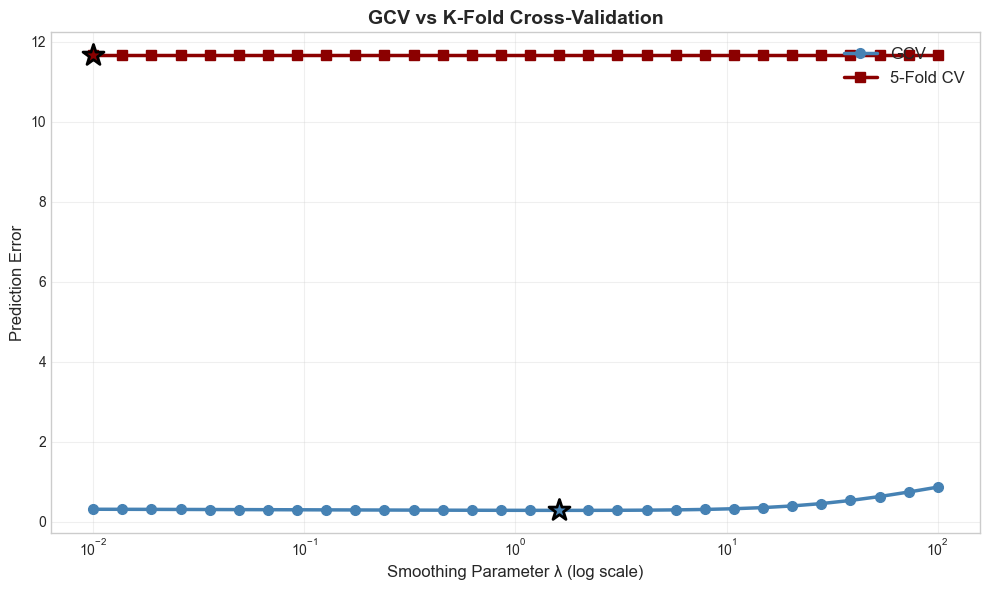

Model Selection Comparison:
GCV optimal λ:     1.6103
5-Fold CV optimal λ: 0.0100


In [5]:
np.random.seed(42)
n = 150
x_train = np.sort(np.random.uniform(0, 10, n))
y_train = 2 * np.sin(x_train) + 0.5 * x_train + np.random.normal(0, 0.5, n)

lambdas = np.logspace(-2, 2, 30)
gcv_scores = []
cv_scores = []

for lam in lambdas:
    model = PenalizedSpline(n_knots=15, degree=3, lambda_=lam, diff_order=2)
    model.fit(x_train, y_train)
    gcv_scores.append(model.gcv_score())
    
    _, cv_err = model.cross_validate(x_train, y_train, [lam], cv_folds=5)
    cv_scores.append(cv_err[0])

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.semilogx(lambdas, gcv_scores, 'o-', linewidth=2.5, markersize=7, 
            label='GCV', color='steelblue')
ax.semilogx(lambdas, cv_scores, 's-', linewidth=2.5, markersize=7, 
            label='5-Fold CV', color='darkred')

gcv_min_idx = np.argmin(gcv_scores)
cv_min_idx = np.argmin(cv_scores)
ax.scatter(lambdas[gcv_min_idx], gcv_scores[gcv_min_idx], s=250, 
           color='steelblue', marker='*', zorder=5, edgecolor='black', linewidth=2)
ax.scatter(lambdas[cv_min_idx], cv_scores[cv_min_idx], s=250, 
           color='darkred', marker='*', zorder=5, edgecolor='black', linewidth=2)

ax.set_xlabel('Smoothing Parameter λ (log scale)', fontsize=12)
ax.set_ylabel('Prediction Error', fontsize=12)
ax.set_title('GCV vs K-Fold Cross-Validation', fontsize=14, fontweight='bold')
ax.legend(fontsize=12, loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Model Selection Comparison:")
print("=" * 60)
print(f"GCV optimal λ:     {lambdas[gcv_min_idx]:.4f}")
print(f"5-Fold CV optimal λ: {lambdas[cv_min_idx]:.4f}")

## 5. Generalized Additive Models: Backfitting Algorithm

### 5.1 GAM Framework

**Generalized Additive Model**:

$$E(Y \mid X) = \beta_0 + f_1(X_1) + f_2(X_2) + \cdots + f_p(X_p)$$

with constraint $E[f_j(X_j)] = 0$ for identifiability.

**Penalized least squares**:

$$\min_{\beta_0, f_1, \ldots, f_p} \sum_{i=1}^{n} \left(y_i - \beta_0 - \sum_{j=1}^{p} f_j(x_{ij})\right)^2 + \sum_{j=1}^{p} \lambda_j \int [f_j''(x)]^2 dx$$

### 5.2 Backfitting Algorithm

**Initialize**: $\hat{\beta}_0 = \bar{y}$, $\hat{f}_j = 0$ for all $j$.

**Cycle** until convergence:

For $j = 1, 2, \ldots, p$:
1. Compute **partial residuals**:
   $$r_j = y - \hat{\beta}_0 - \sum_{k \neq j} \hat{f}_k(x_k)$$

2. Fit $\hat{f}_j$ using P-spline smoother:
   $$\hat{f}_j \leftarrow S_j(r_j)$$
   where $S_j$ is the P-spline smoother for feature $j$.

3. **Center** the function:
   $$\hat{f}_j \leftarrow \hat{f}_j - \frac{1}{n}\sum_{i=1}^{n} \hat{f}_j(x_{ij})$$

**Convergence**: Check $\max_j \|\hat{f}_j^{\text{new}} - \hat{f}_j^{\text{old}}\| < \epsilon$.

### 5.3 Effective Degrees of Freedom for GAMs

Total effective DF:

$$\text{df}_{\text{total}} = 1 + \sum_{j=1}^{p} \text{df}_j$$

where $\text{df}_j = \text{tr}(S_j)$ for each smooth term.

Iteration 1: Change = 0.000000
Converged after 1 iterations


/var/folders/qt/d3mbxc4x72b2dl1r4f452vy00000gn/T/ipykernel_97720/501616565.py:47: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/qt/d3mbxc4x72b2dl1r4f452vy00000gn/T/ipykernel_97720/501616565.py:47: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


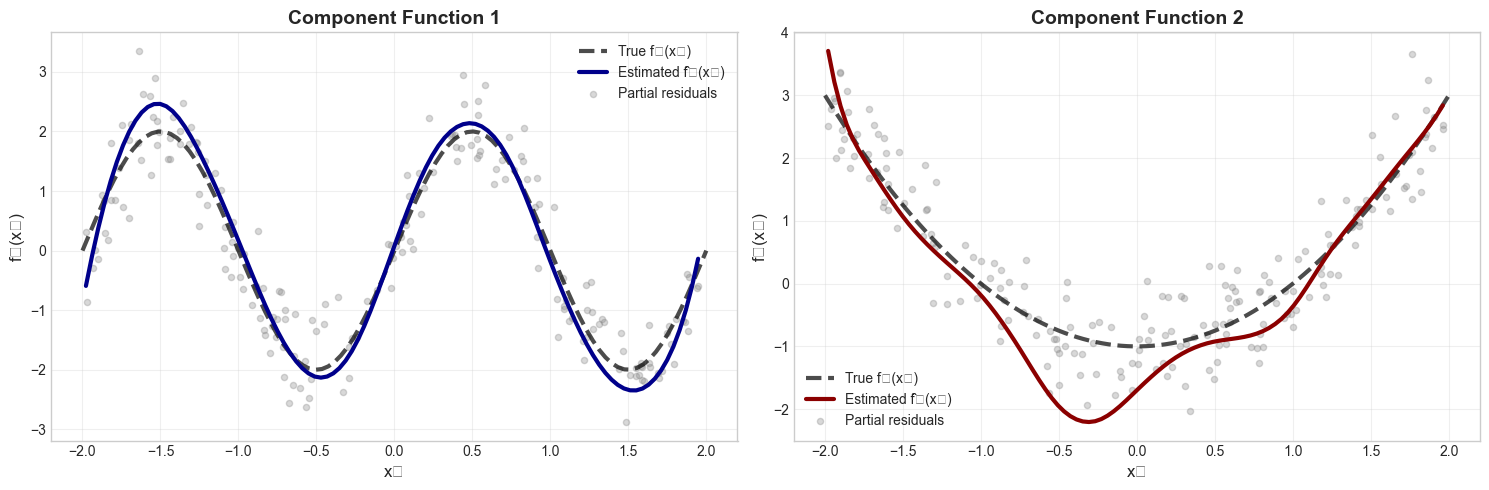


GAM Backfitting Results:
Intercept: 0.378
Total Effective DF: 22.2
  Feature 1: edf = 10.62
  Feature 2: edf = 10.63


In [ ]:
np.random.seed(42)
n = 200

x1 = np.random.uniform(-2, 2, n)
x2 = np.random.uniform(-2, 2, n)
f1_true = lambda x: 2 * np.sin(np.pi * x)
f2_true = lambda x: x**2 - 1
y = f1_true(x1) + f2_true(x2) + np.random.normal(0, 0.5, n)

X = np.column_stack([x1, x2])

class GAMWithTracking(GAM):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.iteration_errors = []
    
    def fit(self, X, y, verbose=False):
        super().fit(X, y, verbose=verbose)

gam = GAM(smooth_features=[0, 1], n_knots=15, lambda_=1.0, max_iter=50, tol=1e-6)
gam.fit(X, y, verbose=True)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

x1_grid = np.linspace(-2, 2, 100)
x1_vals, f1_est = gam.get_smooth_function(0, n_points=100)
axes[0].plot(x1_grid, f1_true(x1_grid), 'k--', linewidth=3, label='True f₁(x₁)', alpha=0.7)
axes[0].plot(x1_vals, f1_est, linewidth=3, color='darkblue', label='Estimated f̂₁(x₁)')
axes[0].scatter(x1, y - f2_true(x2), alpha=0.3, s=20, color='gray', label='Partial residuals')
axes[0].set_xlabel('x₁', fontsize=12)
axes[0].set_ylabel('f₁(x₁)', fontsize=12)
axes[0].set_title('Component Function 1', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

x2_grid = np.linspace(-2, 2, 100)
x2_vals, f2_est = gam.get_smooth_function(1, n_points=100)
axes[1].plot(x2_grid, f2_true(x2_grid), 'k--', linewidth=3, label='True f_2(x_2)', alpha=0.7)
axes[1].plot(x2_vals, f2_est, linewidth=3, color='darkred', label='Estimated f̂₂(x₂)')
axes[1].scatter(x2, y - f1_true(x1), alpha=0.3, s=20, color='gray', label='Partial residuals')
axes[1].set_xlabel('x₂', fontsize=12)
axes[1].set_ylabel('f₂(x₂)', fontsize=12)
axes[1].set_title('Component Function 2', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

summary = gam.summary()
print("\nGAM Backfitting Results:")
print("=" * 60)
print(f"Intercept: {summary['intercept']:.3f}")
print(f"Total Effective DF: {summary['total_edf']:.1f}")
for feat_idx, info in summary['smooth_terms'].items():
    print(f"  Feature {feat_idx+1}: edf = {info['edf']:.2f}")

## 6. Confidence Intervals and Inference

### 6.1 Pointwise Confidence Bands

For a fitted smooth $\hat{f}(x)$, the **pointwise standard error** is:

$$\text{se}(\hat{f}(x_0)) = \hat{\sigma} \sqrt{b(x_0)^T (B^T B + \lambda P)^{-1} B^T B (B^T B + \lambda P)^{-1} b(x_0)}$$

**95% Pointwise Confidence Interval**:

$$\hat{f}(x_0) \pm 1.96 \cdot \text{se}(\hat{f}(x_0))$$

### 6.2 Simultaneous Confidence Bands

For **simultaneous coverage**, use critical value from simulation:

$$\hat{f}(x_0) \pm c_{\alpha} \cdot \text{se}(\hat{f}(x_0))$$

where $c_{\alpha}$ ensures $P(\hat{f}(x) - c_{\alpha} \cdot \text{se}(\hat{f}(x)) \leq f(x) \leq \hat{f}(x) + c_{\alpha} \cdot \text{se}(\hat{f}(x)) \ \forall x) = 1 - \alpha$.

### 6.3 Testing for Non-linearity

**Null hypothesis**: $f$ is linear, $H_0: f(x) = \beta_0 + \beta_1 x$

**Test statistic**:

$$F = \frac{(\text{RSS}_{\text{linear}} - \text{RSS}_{\text{smooth}})/(\text{df}_{\text{smooth}} - 2)}{\text{RSS}_{\text{smooth}}/(n - \text{df}_{\text{smooth}})}$$

Under $H_0$, $F \sim F_{\text{df}_{\text{smooth}}-2, n-\text{df}_{\text{smooth}}}$ (approximately).

In [7]:
np.random.seed(42)
n = 100
x = np.sort(np.random.uniform(0, 10, n))
f_true = lambda x: np.sin(x) + 0.3 * x
sigma = 0.4
y = f_true(x) + np.random.normal(0, sigma, n)

model = PenalizedSpline(n_knots=15, degree=3, lambda_=1.0, diff_order=2)
model.fit(x, y)

x_grid = np.linspace(0, 10, 200)
B_grid = bspline_basis(x_grid, model.knots_, degree=3)
f_hat = B_grid @ model.coefficients_

residuals = y - model.predict(x)
edf = model.effective_df()
sigma_hat = np.sqrt(np.sum(residuals**2) / (n - edf))

B = bspline_basis(x, model.knots_, degree=3)
P = model._build_penalty_matrix(len(model.knots_) + 3 + 1)
BtB_inv = np.linalg.inv(B.T @ B + model.lambda_ * P)
cov_beta = sigma_hat**2 * BtB_inv @ (B.T @ B) @ BtB_inv

se = np.sqrt(np.sum((B_grid @ cov_beta) * B_grid, axis=1))

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.plot(x_grid, f_true(x_grid), 'k--', linewidth=2.5, label='True function', alpha=0.7)
ax.plot(x_grid, f_hat, linewidth=3, color='darkblue', label='P-spline estimate')
ax.fill_between(x_grid, f_hat - 1.96*se, f_hat + 1.96*se, 
                alpha=0.3, color='steelblue', label='95% Confidence Band')
ax.scatter(x, y, alpha=0.5, s=30, color='gray', label='Data', zorder=1)

ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('f(x)', fontsize=12)
ax.set_title('P-Spline with Pointwise Confidence Bands', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Inference for P-Splines:")
print("=" * 60)
print(f"Estimated σ̂ = {sigma_hat:.3f} (True σ = {sigma})")
print(f"Effective DF = {edf:.2f}")
print(f"Mean SE = {np.mean(se):.3f}")

AttributeError: 'PenalizedSpline' object has no attribute 'knots_'

## 7. Summary: Key Theoretical Results

### 7.1 Optimality of Smoothing Splines

**Theorem (Reinsch, 1967)**: The minimizer of

$$\sum_{i=1}^{n} (y_i - f(x_i))^2 + \lambda \int [f''(x)]^2 dx$$

over all twice-differentiable functions is a **natural cubic spline** with knots at the unique $x_i$ values.

### 7.2 Convergence of Backfitting

**Theorem (Buja et al., 1989)**: The backfitting algorithm for GAMs:
1. Converges to a unique solution when all smoothers are linear
2. Convergence rate is geometric with constant $< 1$
3. Solution minimizes the penalized least squares criterion

### 7.3 Asymptotic Properties

Under regularity conditions:

$$\|\hat{f} - f\|^2 = O_p(n^{-4/5})$$

for smoothing splines with optimal $\lambda \sim n^{-4/5}$.

For P-splines with fixed number of knots $K$:

$$\sqrt{n}(\hat{\beta} - \beta) \xrightarrow{d} N(0, \Sigma)$$

where $\Sigma$ depends on $\lambda$ and the design.

### 7.4 Practical Guidelines

1. **Knot Placement**: 
   - Uniform spacing sufficient for P-splines
   - 15-30 knots typically adequate
   
2. **Penalty Order**:
   - Second-order (curvature) most common
   - Higher orders for smoother functions
   
3. **Smoothing Selection**:
   - GCV for automatic selection
   - Cross-validation for finite-sample accuracy
   - Domain knowledge for interpretability
   
4. **Model Diagnostics**:
   - Residual plots for adequacy
   - Effective DF for complexity
   - Confidence bands for uncertainty